In [1]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Setup

In [2]:
# ns = [0,10,10,11,12,13,14,15,16,17]
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# ns = [0]




# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 5
# # arrs = np.array([[20,0,0,0,0],
# #                  [19,19,0,0,0],
# #                  [18,18,18,0,0],
# #                  [17,17,17,17,0],
# #                  [16,16,16,16,16],])
# arrs = np.array([[20,0,0,0,0],
#                  [15,16,17,18,19],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                 ])
# arrs = arrs / 20
# display(arrs)
# display(arrs.sum().round(2))

ms = 2

if ms == 10:
    students = np.logspace(-2, 1, 13)
    ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
    arrs = np.array([[1,0,0,0,0,0,0,0,0,0],
                     [.95,.9,.85,.8,.75,.7,.65,.6,.55,.5],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                    ])
    display(arrs)
    display(arrs.sum().round(2))
                 
elif ms == 2:
    students = np.logspace(-2, 2, 17)
    ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
    arrs = np.array([[1,0],[.95,.90]])
    display(arrs)
    display(arrs.mean().round(2))


ranked = False
top2 = True


slip = False
# students = np.linspace(0.05, 0.5, 10)

display(students.round(3))

array([[1.  , 0.  ],
       [0.95, 0.9 ]])

0.71

array([  0.01 ,   0.018,   0.032,   0.056,   0.1  ,   0.178,   0.316,   0.562,   1.   ,   1.778,   3.162,   5.623,  10.   ,  17.783,  31.623,  56.234, 100.   ])

In [3]:
def make_model(num_nodes=128, num_dense=4):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)
    
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x/b) / np.exp(x/b).sum(axis=axis, keepdims=True)

def make_x():
    x = arrs
    
    # rand = np.random.random(arrs.shape)
    # rand = (rand - 0.5)
    # x = x + rand*0.0001
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree).numpy()
        
        if top2:
            y_pred[0,2:] = 0
            y_pred[0] = y_pred[0] / y_pred[0].sum()
        
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:]).sum(axis=1)
        rewards.append(y_pred[0])
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b=1, n=1, disable=True):
    X, Y = [], []
    for _ in trange(n, disable=disable):
        
        if ranked:
            x = make_x()
            r1 = softmax(rankdata(x,axis=1), b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(rankdata(r1sum), b)
                    
        else:
            x = make_x()
            r1 = softmax(x, b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(r1sum, b)
        
        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        
        
        # slip_prob = np.log10(b)/-20 + 0.95
        slip_prob = b
        
        if slip == False:
            if top2:
                p = np.zeros_like(r0)
                p[:2] = r0[:2]
                p = p / p.sum()
            else:
                p = r0
            y0 = rng.choice(np.arange(ms), p=p)
        else:
            if top2:
                p = np.zeros_like(r0)
                p[0:2] = [1-slip_prob, slip_prob]
            else:
                p = np.zeros_like(r0)
                p[0] = 1-slip_prob
                p[1:] = slip_prob/(ms-1)
            y0 = rng.choice(np.arange(ms), p=p)
        # while y0 in [2,3,4]:
        #     y0 = rng.choice(np.arange(ms), p=r0)
            
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        
        if slip == False:
            y1 = rng.choice(np.arange(ms), p=r1[y0])
        else:
            p = np.zeros(ms) + (slip_prob)/(ms-1)
            p[r1.argmax()] = 1 - slip_prob
            y1 = rng.choice(np.arange(ms), p=p)

        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [4]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        
        if ranked:
            r1 = (softmax(rankdata(x,axis=1), b) * x).sum(axis=1)
            r0 = (softmax(rankdata(r1), b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
            
        else:
            r1 = (softmax(x, b) * x).sum(axis=1)
            r0 = (softmax(r1, b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
    
        
    r1s = np.array(r1s)
    r0s = np.array(r0s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0).round(3)}, {softmax(r1s.mean(axis=0), b).round(3)}")

0.010, 1.000, [1.   0.95], [0.994 0.006]
0.018, 0.997, [1.    0.947], [0.951 0.049]
0.032, 0.992, [1.    0.941], [0.864 0.136]
0.056, 0.984, [1.    0.935], [0.759 0.241]
0.100, 0.977, [1.    0.931], [0.666 0.334]
0.178, 0.969, [0.996 0.928], [0.594 0.406]
0.316, 0.944, [0.959 0.927], [0.526 0.474]
0.562, 0.893, [0.855 0.926], [0.469 0.531]
1.000, 0.838, [0.731 0.926], [0.452 0.548]
1.778, 0.793, [0.637 0.925], [0.46 0.54]
3.162, 0.761, [0.578 0.925], [0.473 0.527]
5.623, 0.741, [0.544 0.925], [0.483 0.517]
10.000, 0.729, [0.525 0.925], [0.49 0.51]
17.783, 0.722, [0.514 0.925], [0.494 0.506]
31.623, 0.718, [0.508 0.925], [0.497 0.503]
56.234, 0.716, [0.504 0.925], [0.498 0.502]
100.000, 0.714, [0.502 0.925], [0.499 0.501]
CPU times: user 5.88 s, sys: 25.5 ms, total: 5.91 s
Wall time: 5.91 s


In [5]:
def train_model(i, student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/2x{ms}/starting_{student:.3f}_{i}.keras')
    # model.save_weights(f'models/starting_{student:.3f}_{i}.weights.h5')
    return reward

In [ ]:
%%time

iters = list(range(10))
iter_students = [100 for i in iters]
rewards = process_map(train_model, iters, iter_students, disable=False, max_workers=20)

# rewards = process_map(train_model, students, disable=True, max_workers=17)

In [ ]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

In [4]:
%%time
ntotal = (2**np.array(ns[1:13])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 111 ms, sys: 244 ms, total: 354 ms
Wall time: 9.84 s


# Eval Training

In [68]:
def eval_training(modeli, student, teachers, save, pct=0):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
    
    def get_r(model):
        r0, r1 = eval_model(model, 10)
        r = (r0*r1).sum(axis=1).mean()
        return r
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()
        def on_batch_begin(self, batch, logs=None):            
            if save and batch % 1 == 0:
                r = get_r(self.model)
                try:
                    self.model.rewards[batch] = r
                except:
                    self.model.rewards = {batch: r}
    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/2x{ms}/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    
    bs = 32
    
    rng = np.random.default_rng(modeli)
    
    X, Y = [], []
    for teacher, n in teachers:
        if isinstance(teacher, tuple):
            X.append([])
            Y.append([])
            for teacher_part in teacher:
                _X, _Y = currs[f"{teacher_part:.3f}"]
                perm = np.random.default_rng(modeli).permutation(len(_X))[:bs * n//len(teacher)]
                # perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                X[-1].append(_X[perm])
                Y[-1].append(_Y[perm])
            X[-1] = np.concatenate(X[-1])
            Y[-1] = np.concatenate(Y[-1])
            perm = np.random.permutation(len(X[-1]))
            X[-1] = X[-1][perm]
            Y[-1] = Y[-1][perm]
        else:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])

    lx = len(X[0])
    if pct:
        assert (pct*lx) % 1 == 0
        pct2 = int(pct * lx)
        mixX = np.concatenate([_X[lx-pct2:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct2:] for _Y in Y])
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct2:] = mixX[i::len(X)]
            _Y[lx-pct2:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
    
    X, Y = np.concatenate(X), np.concatenate(Y)        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()]) 
    
    final_reward = get_r(model2)
    try:
        model2.rewards[len(X)//bs] = final_reward
    except:
        model2.rewards = {len(X)//bs: final_reward}
        
        
    with open('/storage1/fs1/chien-ju.ho/Active/gym/tree.txt', 'a') as f:
        for k, v in model2.rewards.items():
            print(f"{student};{teachers};{pct};{modeli};{k};{v}", file=f, flush=True)

    return (modeli, student, teachers, model2.rewards)


In [28]:
def exp(student, verbose=True, n=20, nb=100, mode='one', algo=None, pct=0):
        
    if mode == 'one':
        teachers = [
            [(0.010, nb)],
            [(0.032, nb)],
            [(0.100, nb*3)],
            [(0.316, nb)],
            [(1.000, nb)],
            [(3.162, nb)],
            [(10.000, nb)],
        ]
        
    elif mode == 'two-1':
        teachers = [
            [((0.010,0.100,1.000,10.00), nb)],
            [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
            [(10.00, nb//4), (1.000, nb//4), (0.100, nb//4), (0.010, nb//4)],
        ]
    elif mode == 'two-2':
        teachers = [
            [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
        ]
        
    elif mode.startswith('three'):
        k = int(mode[-1])
        teachers = [[(0.1, i*k), (0.01, i)] for i in range(1, nb//2+1)]
        
    # elif mode == 'three-1':
    #     teachers = [[(0.1, i), (0.01, i)] for i in range(1, nb//2+1)]
    # elif mode == 'three-2':
    #     teachers = [[(0.1, i*2), (0.01, i)] for i in range(1, nb//2+1)]
    # elif mode == 'three-3':
    #     teachers = [[(0.1, i*3), (0.01, i)] for i in range(1, nb//2+1)]
        
            
    # elif mode == 'algo-1':
    #     teachers = []
    #     for i in range(1, 11):
    #         for split in range(1, i):
    #             t0, t1 = [(0.1, nb*0.1*split)], [(0.01, nb*0.1*(i-split))]
    #             teachers.append(t0 + [(0.1, nb*0.1)] + t1)
    #             teachers.append(t0 + t1 + [(0.01, nb*0.1)])
    # elif mode == 'algo-2':
    #     teachers = []
    #     for i in range(1, 11):
    #         for split in range(1, i):
    #             t0, t1 = [(0.1, nb*0.2*split)], [(0.01, nb*0.1*(i-split))]
    #             teachers.append(t0 + [(0.1, nb*0.2)] + t1)
    #             teachers.append(t0 + t1 + [(0.01, nb*0.1)])
    # elif mode == 'algo-3':
    #     teachers = []
    #     for i in range(1, 11):
    #         for split in range(1, i):
    #             t0, t1 = [(0.1, nb*0.3*split)], [(0.01, nb*0.1*(i-split))]
    #             teachers.append(t0 + [(0.1, nb*0.3)] + t1)
    #             teachers.append(t0 + t1 + [(0.01, nb*0.1)])
                        
    elif mode.startswith('algo'):
        k = int(mode[-1])
        n0, n2 = algo
        teachers = []
        teachers.append([(0.1, n0*k), (0.1, 10*k), (0.01, n2)])
        teachers.append([(0.1, n0*k), (0.01, n2), (0.01, 10)])
        
                
            
    elif mode.starswith('optimal'):
        k = int(mode[-1])
        teachers = []
        for i in range(1, 11):
            for split in range(1, i):
                t0, t1 = [(0.1, nb*0.1*k*split)], [(0.01, nb*0.1*(i-split))]
                teachers.append(t0+t1)


                
    
    t_, s_, iters, saves, pcts = [], [], [], [], []
    for teacher in teachers:
        for i in range(n):
            t_.append([(t1, int(t2)) for t1, t2 in teacher])
            s_.append(student)
            iters.append(i)
            if mode.startswith('three') or mode.startswith('optimal') or mode.startswith('algo'):
                saves.append(False)
            else:
                saves.append(True)
                
            pcts.append(pct)
        
    res = process_map(eval_training, iters, s_, t_, saves, pcts, max_workers=21, chunksize=1)
    return res

In [69]:
%%time

path = []
algo = [10, 10]
while np.sum(algo) < 100:
    print(algo)
    res = exp(100, n=10, nb=100, mode='algo-1', pct=0, algo=algo)
    res = pd.DataFrame(res, columns=['i','student','teacher','reward'])
    res['reward'] = res.reward.apply(lambda x: list(x.values())[0])
    res['teacher'] = res.teacher.apply(tuple)
    res = res.groupby('teacher').reward.mean()
    res = res.sort_index(ascending=False)
    path.append([[algo.copy()], res.values.max()])
    algo[res.values.argmax()] += 10
print(algo)
print(path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[30, 70]
CPU times: user 326 ms, sys: 2.13 s, total: 2.46 s
Wall time: 1min 9s


[[[[10, 10]], 0.7135425066073825],
 [[[20, 10]], 0.7220351429191749],
 [[[30, 10]], 0.7554845852405501],
 [[[30, 20]], 0.8232495681316836],
 [[[30, 30]], 0.9044236833166994],
 [[[30, 40]], 0.9539934447659579],
 [[[30, 50]], 0.9910345781882258],
 [[[30, 60]], 0.99886719688323]]

In [92]:
args = []
    
for pct in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    args.append(['two-2', pct])
    
for mode in ['one','two-1','three-1','three-2','three-3','optimal-1','optimal-2','optimal-3','algo-1','algo-2','algo-3']:
    args.append([mode, 0])

args

[['two-2', 0],
 ['two-2', 0.2],
 ['two-2', 0.4],
 ['two-2', 0.6],
 ['two-2', 0.8],
 ['two-2', 1],
 ['one', 0],
 ['two-1', 0],
 ['three-1', 0],
 ['three-2', 0],
 ['three-3', 0],
 ['optimal-1', 0],
 ['optimal-2', 0],
 ['optimal-3', 0],
 ['algo-1', 0],
 ['algo-2', 0],
 ['algo-3', 0]]

In [95]:
%%time
for mode, pct in args:
    _ = exp(100, n=10, nb=100, mode=mode, pct=pct)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

CPU times: user 5.45 s, sys: 6.77 s, total: 12.2 s
Wall time: 9min 28s


# Results

In [97]:
%%time
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df1 = df.groupby(['Student','Teacher','Pct','Batch','Exp']).Perf.mean().reset_index()
df1 = df1.groupby(['Student','Teacher','Pct','Batch']).Perf.agg(['mean','std','sem','count']).reset_index()
df1 = df1.rename(columns={'mean':'Perf', 'std':'SD', 'sem':'SE'})
df1

CPU times: user 2.38 s, sys: 202 ms, total: 2.59 s
Wall time: 2.63 s


,Student,Teacher,Pct,Batch,Perf,SD,SE,count
0,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0.0,0,0.713282,0.001569,0.000050,1000
1,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0.0,1,0.713151,0.001584,0.000050,1000
2,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0.0,2,0.713141,0.001679,0.000053,1000
3,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0.0,3,0.712945,0.001648,0.000052,1000
4,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0.0,4,0.712824,0.001805,0.000057,1000
...,...,...,...,...,...,...,...,...
2009,100,"[(3.162, 100)]",0.0,96,0.720967,0.005620,0.000178,1000
2010,100,"[(3.162, 100)]",0.0,97,0.720970,0.005535,0.000175,1000
2011,100,"[(3.162, 100)]",0.0,98,0.721329,0.005761,0.000182,1000
2012,100,"[(3.162, 100)]",0.0,99,0.721394,0.005857,0.000185,1000


In [98]:
subs = {}
nb = 100

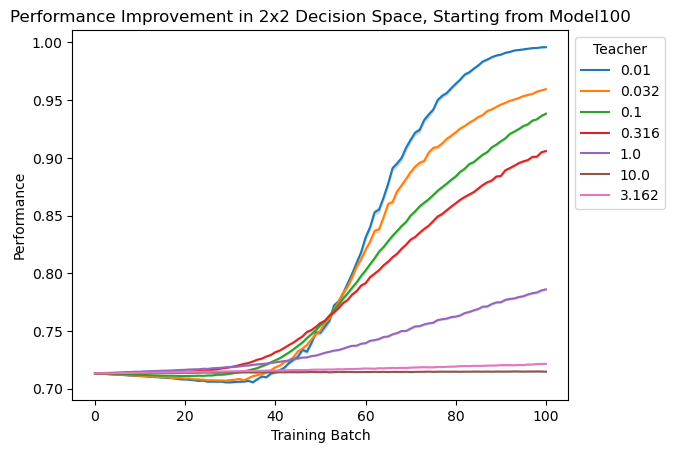

In [99]:
subs['one'] = [str([(k, int(v)) for k,v in i]) for i in [
    [(0.010, nb)],
    [(0.032, nb)],
    [(0.100, nb*3)],
    [(0.316, nb)],
    [(1.000, nb)],
    [(3.162, nb)],
    [(10.000, nb)],
]]

df2 = df[df.Teacher.isin(subs['one'])]
df2 = df2[df2.Batch <= 100]
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

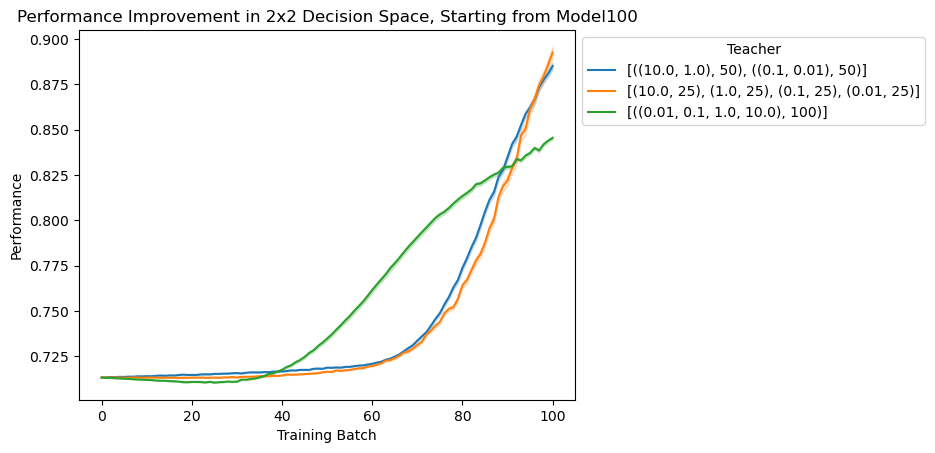

In [100]:
subs['two1'] = [str([(k, int(v)) for k,v in i]) for i in [
    [((0.010,0.100,1.000,10.00), nb)],
    [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
    [(10.00, nb//4), (1.000, nb//4), (0.100, nb//4), (0.010, nb//4)],
]]
df2 = df[df.Teacher.isin(subs['two1']) & (df.Pct == 0)]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

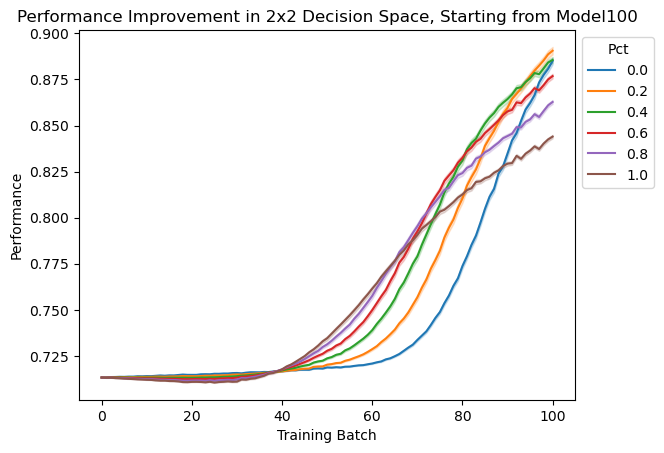

In [101]:
subs['two1'] = [str([(k, int(v)) for k,v in i]) for i in [
    [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
]]
df2 = df[df.Teacher.isin(subs['two1'])].astype({'Pct': 'str'})
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Pct', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

In [108]:
def eval_three(k):
    df2_opt = []
    nb = 100
    for i in range(2, 11):
        perfs = []
        for split in range(1, i):
            t0, t1 = [(0.1, nb*0.1*k*split)], [(0.01, nb*0.1*(i-split))]
            teacher = str([(k, int(v)) for k,v in t0+t1])
            perf = df[df.Teacher==teacher].Perf.mean()
            perfs.append((perf, teacher))
        perfs = sorted(perfs)
        print(i*10, perfs[-1])
        df2_opt.append([100, 'optimal', 0, 0, i*10, perfs[-1][0]])
    df2_opt = pd.DataFrame(df2_opt, columns=['Student','Teacher','Pct','Exp','Batch','Perf'])
    
    df2_algo = []
    algo = [10, 10]
    while np.sum(algo) < 100:
        n0, n2 = algo
        teachers = []
        t0 = str([(0.1, n0*k), (0.1, 10*k), (0.01, n2)])
        t1 = str([(0.1, n0*k), (0.01, n2), (0.01, 10)])

        perf = np.array([df[df.Teacher==t0].Perf.mean(), df[df.Teacher==t1].Perf.mean()])
        algo[perf.argmax()] += 10
        print(np.sum(algo), algo)
        df2_algo.append([100, 'algo', 0, 0, np.sum(algo), perf.max()])
    df2_algo = pd.DataFrame(df2_algo, columns=['Student','Teacher','Pct','Exp','Batch','Perf'])
    
    subs[f'three{k}'] = [str([(0.1, i*k), (0.01, i)]) for i in range(1, nb//2+1)]
    df2_1 = df[df.Teacher.isin(subs[f'three{k}'])].copy()
    df2_1['Teacher'] = 'split'
    df2_2 = df[df.Teacher == f'[(0.01, {nb})]']
    df2_3 = df[df.Teacher == f'[(0.1, {nb*3})]'].copy()
    df2_3['Batch'] = df2_3['Batch'] / k
    df2 = pd.concat([df2_1, df2_2, df2_3, df2_opt, df2_algo])
    df2 = df2[df2.Batch <= 100]
    return df2

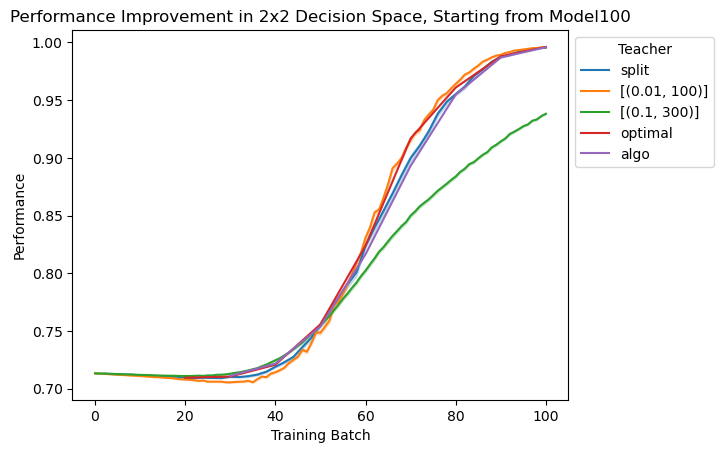

In [103]:
df2 = eval_three(1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

20 (0.7105114201752405, '[(0.1, 20), (0.01, 10)]')
30 (0.7530947390260885, '[(0.1, 40), (0.01, 10)]')
40 (0.8698956970888173, '[(0.1, 60), (0.01, 10)]')
50 (0.9434293342143512, '[(0.1, 60), (0.01, 20)]')
60 (0.9903326056911183, '[(0.1, 80), (0.01, 20)]')
70 (0.997814152685109, '[(0.1, 80), (0.01, 30)]')
80 (0.9990418382621931, '[(0.1, 100), (0.01, 30)]')
90 (0.9992668229609633, '[(0.1, 120), (0.01, 30)]')
100 (0.9994497582236075, '[(0.1, 140), (0.01, 30)]')
30 [20, 10]
40 [30, 10]
50 [40, 10]
60 [40, 20]
70 [40, 30]
80 [50, 30]
90 [60, 30]
100 [70, 30]


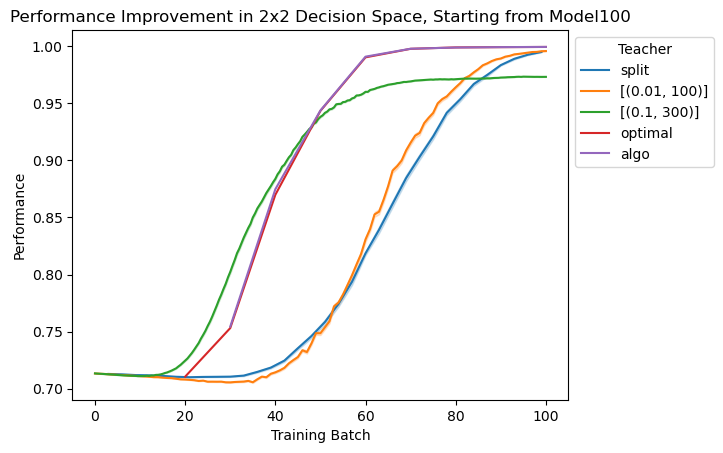

In [109]:
df2 = eval_three(2)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

20 (0.7207690232778239, '[(0.1, 30), (0.01, 10)]')
30 (0.8698956970888173, '[(0.1, 60), (0.01, 10)]')
40 (0.9641196997102744, '[(0.1, 90), (0.01, 10)]')
50 (0.9954521488157028, '[(0.1, 90), (0.01, 20)]')
60 (0.9986061984816164, '[(0.1, 90), (0.01, 30)]')
70 (0.9992668229609633, '[(0.1, 120), (0.01, 30)]')
80 (0.9995519141494105, '[(0.1, 150), (0.01, 30)]')
90 (0.9996052237600144, '[(0.1, 180), (0.01, 30)]')
100 (0.9996473366984222, '[(0.1, 210), (0.01, 30)]')
30 [20, 10]
40 [30, 10]
50 [30, 20]
60 [30, 30]
70 [40, 30]
80 [50, 30]
90 [60, 30]
100 [70, 30]


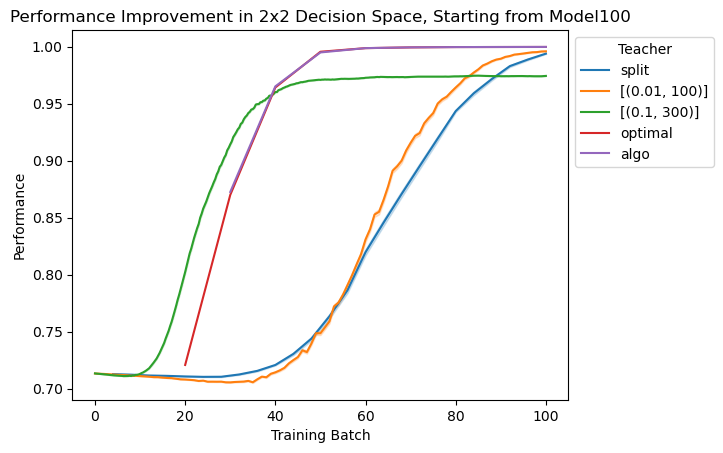

In [110]:
df2 = eval_three(3)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

In [107]:
df2[df2.Teacher=='algo']

,Student,Teacher,Pct,Exp,Batch,Perf
0,100,algo,0.0,0,30.0,0.872460
1,100,algo,0.0,0,40.0,0.965099
2,100,algo,0.0,0,50.0,0.994837
3,100,algo,0.0,0,60.0,0.998628
4,100,algo,0.0,0,70.0,0.999294
5,100,algo,0.0,0,80.0,0.999539
6,100,algo,0.0,0,90.0,0.999619
7,100,algo,0.0,0,100.0,0.999681


# 2x10

In [369]:
n = 500

  0%|          | 0/3500 [00:00<?, ?it/s]

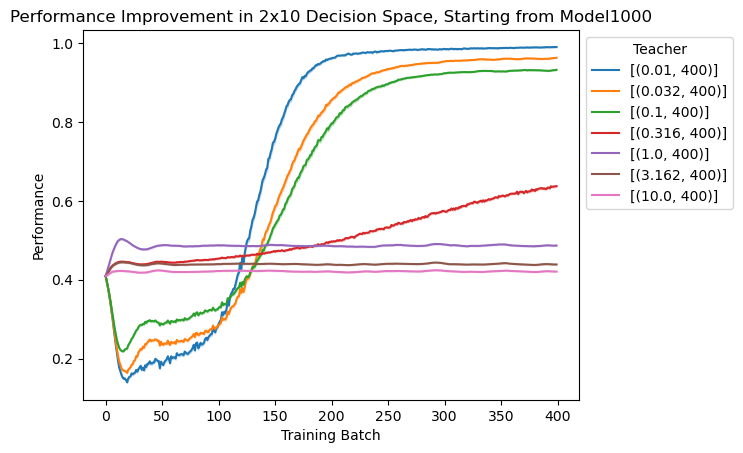

In [370]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model1000',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

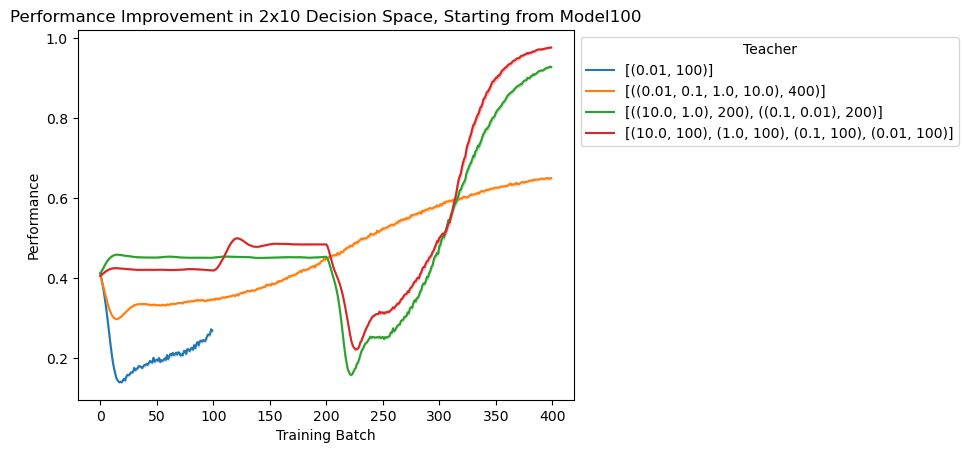

In [371]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

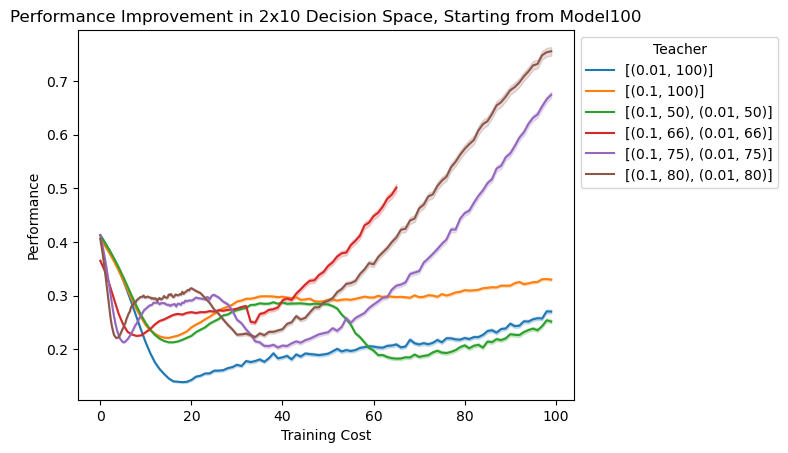

In [372]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

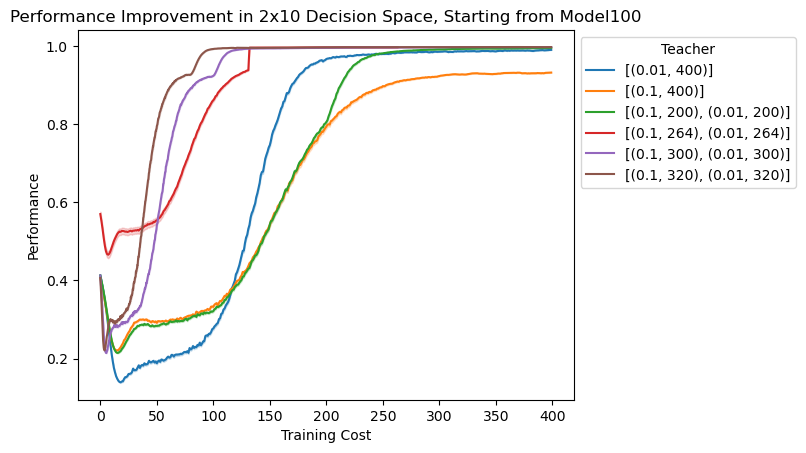

In [373]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )